# Uso de √≠ndice de silhouette

**Autor:** Jazna Meza Hidalgo

**Correo Electr√≥nico:** ja.meza@profesor.duoc.cl

**Fecha de Actualziaci√≥n:** Junio 2024

**Versi√≥n:** 1.0

**Fecha de Actualziaci√≥n:** Enero de 2025

**Versi√≥n:** 1.1  

---

## Descripci√≥n

Este notebook contiene la explicaci√≥n del uso del √≠ndice de silohoutte como m√©trica en problemas de segmentaci√≥n.

Utiliza un dataset de clientes de una instituci√≥n financiera (banco).

Se realiza una segmentaci√≥n de clientes bancarios

---

## Requisitos de Software

Este notebook fue desarrollado con Python 3.9. A continuaci√≥n se listan las bibliotecas necesarias:

- pandas (>=1.1.0)
- numpy (1.26.4)
- matplotlib (3.7.1)
- seaborn (0.13.1)
- sklearn

Para verificar la versi√≥n instalada ejecutar usando el siguiente comando, usando la librer√≠a de la cual quieres saber la versi√≥n:

```bash
import pandas as pd
print(pd.__version__)
````

In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import seaborn as sns
import scipy.stats as stats
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.metrics import silhouette_samples, silhouette_score

from mpl_toolkits.mplot3d import Axes3D

In [3]:
!wget https://raw.githubusercontent.com/JaznaLaProfe/Mineria_de_datos/main/datos/german_credit_data.csv

--2025-05-28 17:36:09--  https://raw.githubusercontent.com/JaznaLaProfe/Mineria_de_datos/main/datos/german_credit_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49689 (49K) [text/plain]
Saving to: ‚Äògerman_credit_data.csv‚Äô

german_credit_data. 100%[===================>]  48.52K  --.-KB/s    in 0.001s  

2025-05-28 17:36:09 (39.5 MB/s) - ‚Äògerman_credit_data.csv‚Äô saved [49689/49689]



In [4]:
data = pd.read_csv("german_credit_data.csv")

Control visual de las primeras filas

In [5]:
data.head()

Unnamed: 0  Age     Sex  Job Housing Saving accounts Checking account  \
0           0   67    male    2     own             NaN           little   
1           1   22  female    2     own          little         moderate   
2           2   49    male    1     own          little              NaN   
3           3   45    male    2    free          little           little   
4           4   53    male    2    free          little           little   

   Credit amount  Duration              Purpose  
0           1169         6             radio/TV  
1           5951        48             radio/TV  
2           2096        12            education  
3           7882        42  furniture/equipment  
4           4870        24                  car

Parece que la primera columna es simplemente un √≠ndice que se puede eliminar. Se verifica cu√°ntos valores faltantes hay en cada columna y de qu√© tipos de datos son.

In [6]:
data.drop(data.columns[0], inplace=True, axis=1)
print("Conjunto tiene {} observaciones (customers) y {} caracter¬¥siticas (attributes).".format(data.shape[0],data.shape[1]))
print("*"*15,"\nValores nulos en cada columna:\n{}".format(data.isnull().sum()))
print("*"*15,"\nTipos de datos:\n{}".format(data.dtypes))

Conjunto tiene 1000 observaciones (customers) y 9 caracter¬¥siticas (attributes).
*************** 
Valores nulos en cada columna:
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64
*************** 
Tipos de datos:
Age                  int64
Sex                 object
Job                  int64
Housing             object
Saving accounts     object
Checking account    object
Credit amount        int64
Duration             int64
Purpose             object
dtype: object


De 8 columnas, 2 contienen valores faltantes. Probablemente se trate de clientes que no tengan ninguna de estas dos cuentas.

Se puede indicar, de forma preliminar, que existen 3 variables num√©ricas y 5 categ√≥ricas.

Ahora, se comprueba cu√°ntos y cu√°les son los valores posibles (√∫nicos) en cada columna categ√≥rica.

In [7]:
n_unique = data.nunique()
print("N√∫mero de valores √∫nicos:\n{}".format(n_unique))

N√∫mero de valores √∫nicos:
Age                  53
Sex                   2
Job                   4
Housing               3
Saving accounts       4
Checking account      3
Credit amount       921
Duration             33
Purpose               8
dtype: int64


In [8]:
print("Valores √∫nicos para cada columna categ√≥rica")
for col in data.select_dtypes(include=[object]):
  print(col,":", data[col].unique())

Valores √∫nicos para cada columna categ√≥rica
Sex : ['male' 'female']
Housing : ['own' 'free' 'rent']
Saving accounts : [nan 'little' 'quite rich' 'rich' 'moderate']
Checking account : ['little' 'moderate' nan 'rich']
Purpose : ['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']


## An√°lisis exploratorio de datos

A continuaci√≥n se define una funci√≥n que generar√° gr√°ficos para tres variables num√©ricas con estratificaci√≥n por columna categ√≥rica seleccionada.

In [9]:
def scatters(data : pd.DataFrame, h=None, pal=None):
  fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,8))
  sns.scatterplot(x="Credit amount",y="Duration", hue=h, palette=pal, data=data, ax=ax1)
  sns.scatterplot(x="Age",y="Credit amount", hue=h, palette=pal, data=data, ax=ax2)
  sns.scatterplot(x="Age",y="Duration", hue=h, palette=pal, data=data, ax=ax3)
  plt.tight_layout()

Se inicia con los diagramas de dispersi√≥n de las 3 variables num√©ricas estratificadas por sexo.

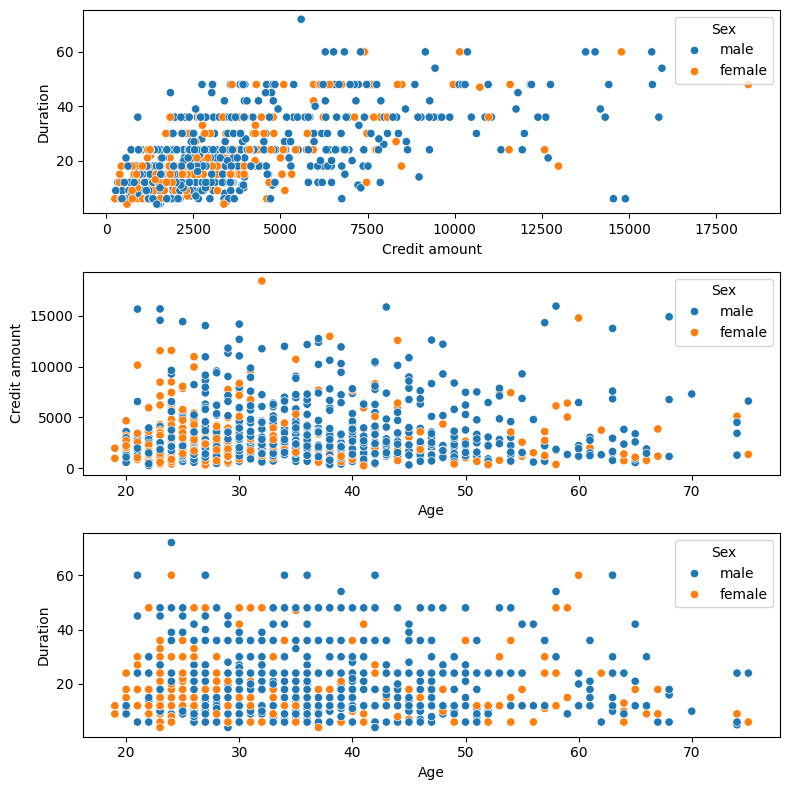

In [10]:
scatters(data, h="Sex")

La impresi√≥n general es que las mujeres tienden a ser m√°s j√≥venes que los hombres, sin embargo, el gr√°fico superior muestra que no hay una diferencia clara entre hombres y mujeres en t√©rminos de monto y duraci√≥n del cr√©dito. A partir de una inspecci√≥n visual, parece que existe cierta correlaci√≥n positiva entre la duraci√≥n y el monto del cr√©dito, lo que tiene sentido.

Ahora, se comprueba la correlaci√≥n lineal entre el importe del cr√©dito y la duraci√≥n.

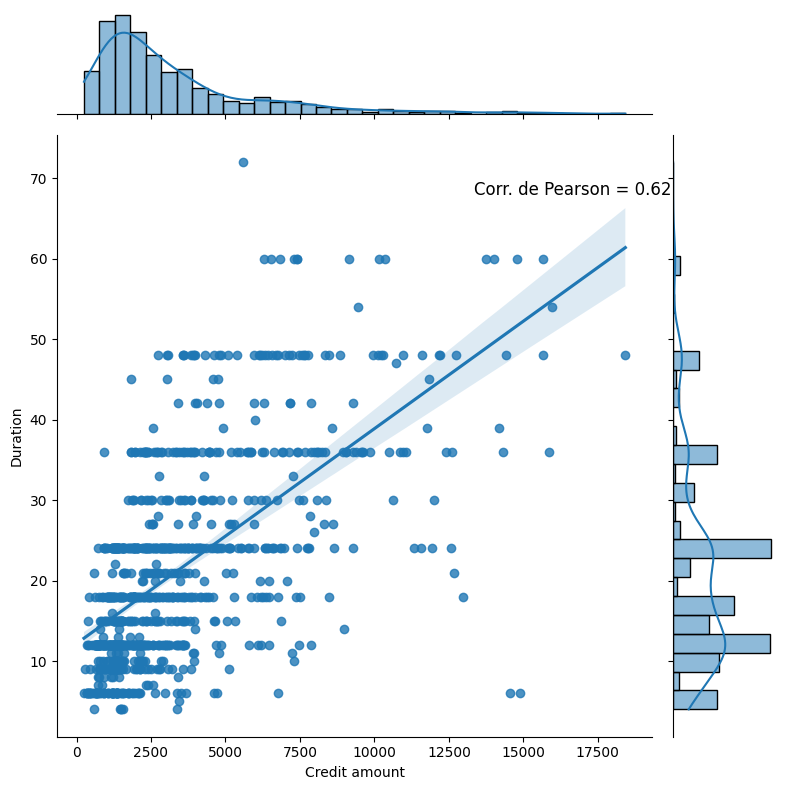

In [11]:
# Crear el jointplot
r1 = sns.jointplot(x="Credit amount", y="Duration", data=data, kind="reg", height=8)

# Calcular la correlaci√≥n de Pearson
pearson_corr, _ = stats.pearsonr(data["Credit amount"], data["Duration"])

# Anotar el gr√°fico con la correlaci√≥n de Pearson
r1.ax_joint.annotate(f"Corr. de Pearson = {pearson_corr:.2f}", xy=(0.7, 0.9),
                     xycoords="axes fraction", fontsize=12)

# Mostrar el gr√°fico
plt.show()


El gr√°fico anterior muestra una correlaci√≥n lineal con el valor de Pearson de 0,62 y un valor p muy peque√±o. Esto tiene sentido porque, por lo general, las personas obtienen cr√©ditos m√°s grandes por per√≠odos m√°s largos. A continuaci√≥n se analizan gr√°ficos de regresi√≥n lineal con varias categorizaciones.

In [12]:
data[["Credit amount", "Duration"]].corr().round(2)

Credit amount  Duration
Credit amount           1.00      0.62
Duration                0.62      1.00

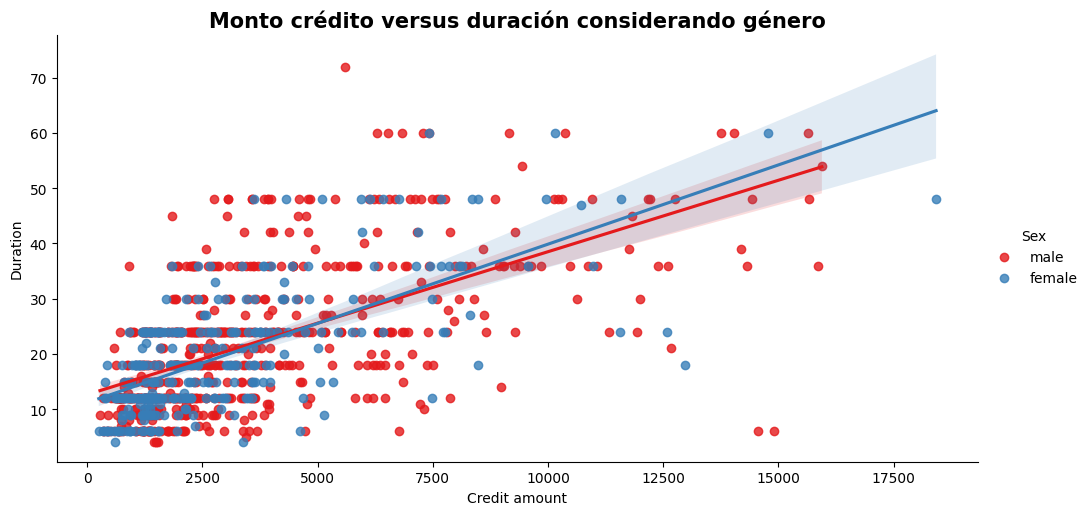

In [13]:
sns.lmplot(x="Credit amount",y="Duration", hue="Sex", data=data, palette="Set1", aspect=2)
plt.title("Monto cr√©dito versus duraci√≥n considerando g√©nero", fontsize=15, fontweight="bold")
plt.show()

El gr√°fico anterior indica que no hay una diferencia significativa entre hombres y mujeres.

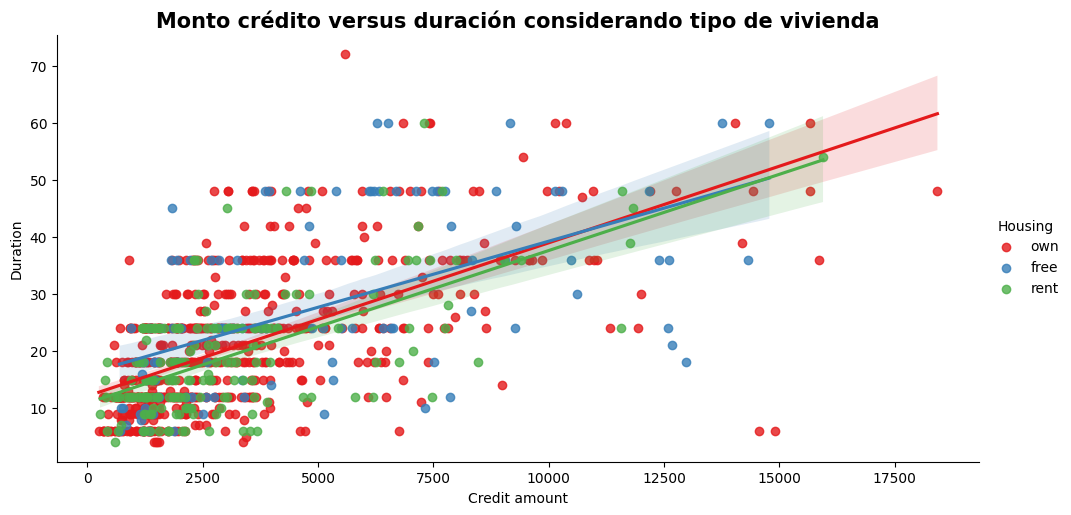

In [14]:
sns.lmplot(x="Credit amount",y="Duration", hue="Housing", data=data, palette="Set1", aspect=2)
plt.title("Monto cr√©dito versus duraci√≥n considerando tipo de vivienda", fontsize=15, fontweight="bold")
plt.show()

El gr√°fico anterior muestra, de manera similar, que no hay diferencias entre las categor√≠as de vivienda.
A continuaci√≥n, se muestra el √°rea de ‚Äúnegocios‚Äù donde se otorga la mayor cantidad de cr√©ditos.

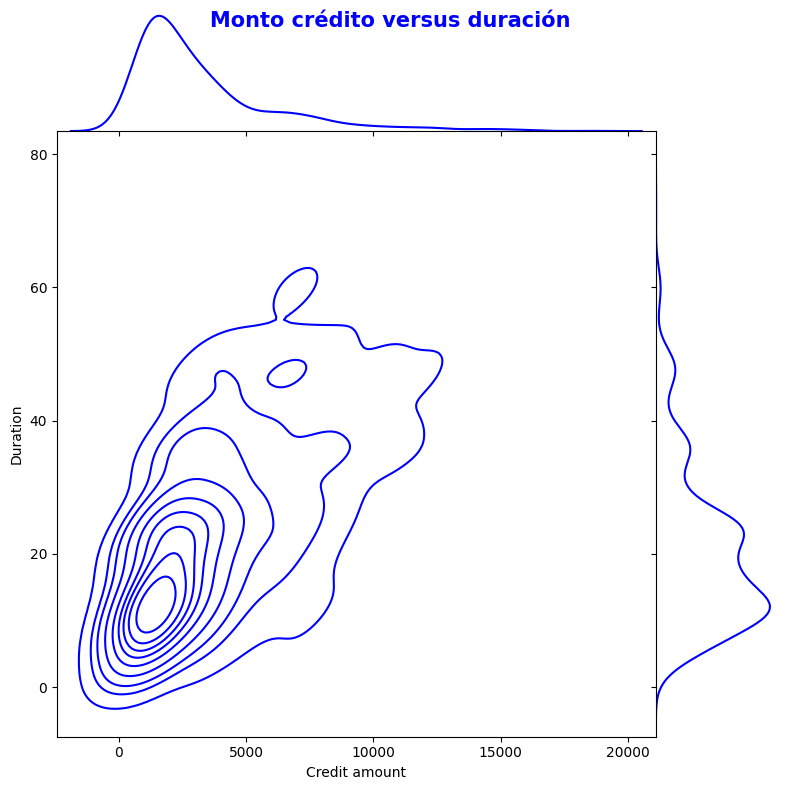

In [15]:
sns.jointplot(x="Credit amount", y="Duration", data=data, kind="kde",
              space=0, color="b", height=8)
plt.suptitle("Monto cr√©dito versus duraci√≥n", fontsize=15, color = "blue", fontweight="bold")
plt.show()


‚úÖ **1. Relaci√≥n entre monto del cr√©dito y duraci√≥n.**
Las l√≠neas de contorno (en azul) indican la densidad de observaciones en cada regi√≥n del plano.

Las zonas con m√°s l√≠neas (m√°s juntas) indican alta concentraci√≥n de casos.

Es posible observar que la mayor densidad se da para montos entre 0 y 5000 y duraciones entre 0 y 40 meses.

üîé Esto indica que la mayor√≠a de los cr√©ditos otorgados fueron por montos bajos y duraciones cortas.

‚úÖ **2. Distribuci√≥n univariada (gr√°ficos marginales)**

Parte superior (Credit amount):
Muestra una alta densidad en cr√©ditos bajos (menores a 5000), con cola larga hacia montos mayores (asimetr√≠a derecha).

Parte derecha (Duration):
La mayor√≠a de los cr√©ditos tienen una duraci√≥n inferior a 40 meses, lo que concuerda con el contorno central.

---
**Interpretaciones**

---

1. El cr√©dito analizado tiende a otorgarse m√°s frecuentemente en montos moderados (0‚Äì5000) y duraciones cortas (0‚Äì40 meses).

2. Cr√©ditos grandes y extensos son menos frecuentes, como se ve en la parte superior derecha del gr√°fico (poca densidad).

3. La forma del gr√°fico sugiere que el monto y la duraci√≥n est√°n correlacionados positivamente: a mayor duraci√≥n, tiende a haber montos m√°s altos, aunque no de forma lineal estricta.

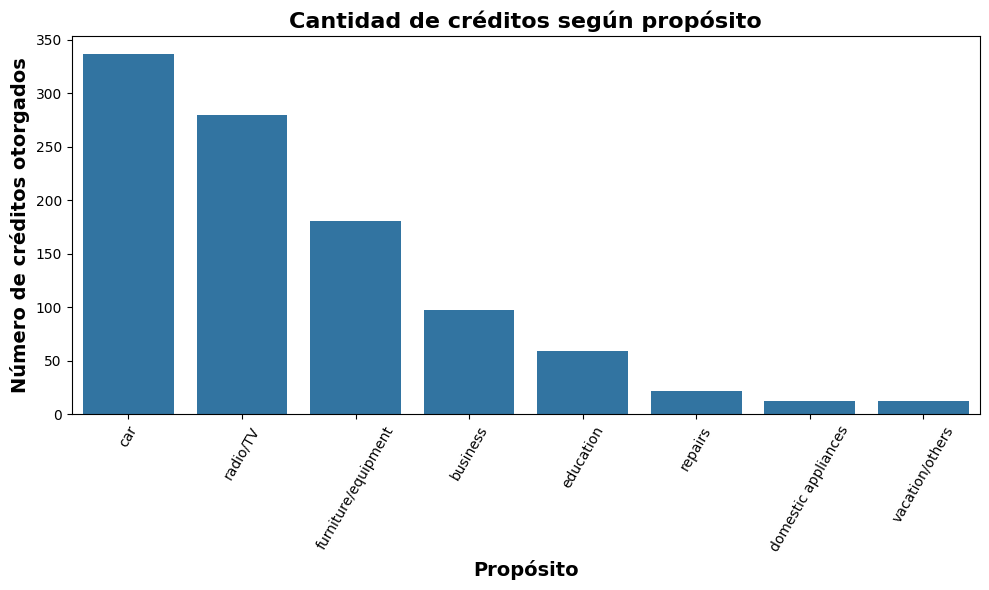

In [17]:
n_credits = data.groupby("Purpose")["Age"].count().rename("Count").reset_index()
n_credits.sort_values(by=["Count"], ascending=False, inplace=True)

plt.figure(figsize=(10,6))
bar = sns.barplot(x="Purpose",y="Count",data=n_credits)
bar.set_xticklabels(bar.get_xticklabels(), rotation=60)
plt.xlabel("Prop√≥sito", fontsize=14, fontweight="bold")
plt.ylabel("N√∫mero de cr√©ditos otorgados", fontsize=14, fontweight="bold")
plt.title("Cantidad de cr√©ditos seg√∫n prop√≥sito", fontsize=16, fontweight="bold")
plt.tight_layout()

El diagrama de barras anterior muestra cu√°ntos cr√©ditos se otorgaron para diversos fines. La mayor√≠a de los cr√©ditos se concedieron para autom√≥viles y radio/TV.

Ahora se generan diagramas de caja para un an√°lisis detallado de variables categ√≥ricas.

In [23]:
def boxes(x : str, y : str, h : str,r=45):
  fig, ax = plt.subplots(figsize=(10,6))
  box = sns.boxplot(x=x,y=y, hue=h, data=data)
  box.set_xticklabels(box.get_xticklabels(), rotation=r)
  fig.subplots_adjust(bottom=0.2)
  plt.title(f"An√°lisis de variables\n{x}-{y}-{h}", fontsize=16, fontweight="bold")
  plt.tight_layout()

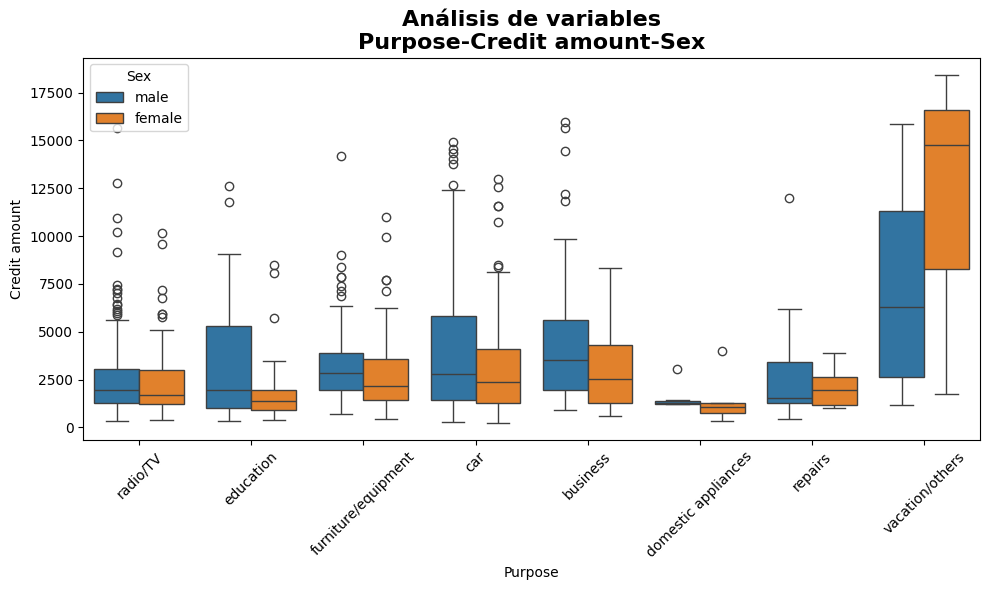

In [24]:
boxes("Purpose","Credit amount","Sex")

El gr√°fico anterior muestra que las cantidades m√°s grandes se toman para vacaciones/otros, y las m√°s peque√±as para electrodom√©sticos. La mayor√≠a de ellos tienen valores at√≠picos en la parte superior de los cuadros (cantidades m√°s altas). En la mayor√≠a de los casos no hay diferencia entre hombres y mujeres, a pesar de la categor√≠a vacaciones/otros. Sin embargo, hay que recordar que hubo muy pocos cr√©ditos concedidos en esta categor√≠a.

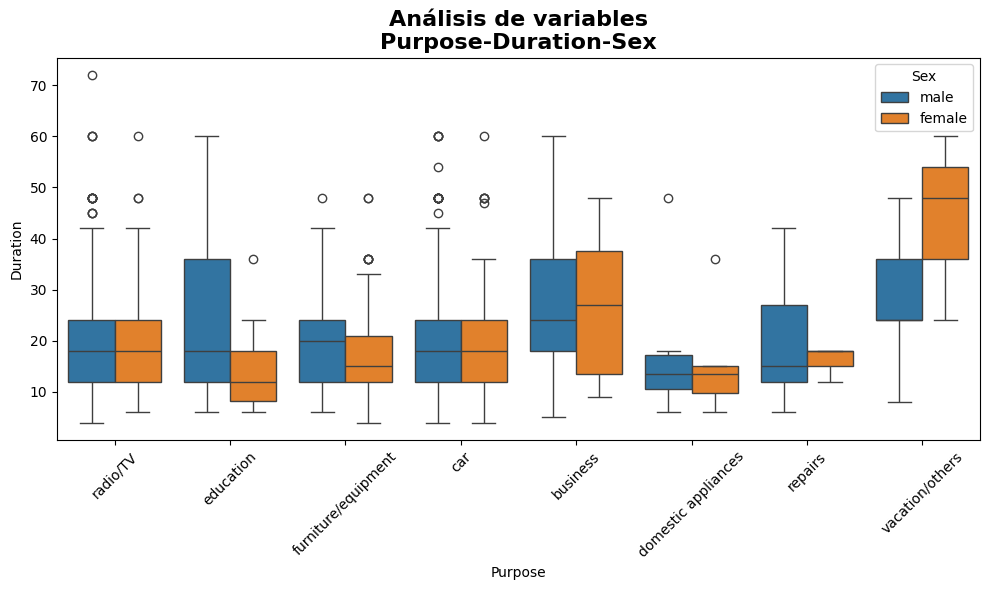

In [25]:
boxes("Purpose","Duration","Sex")

El diagrama de caja anterior indica que, en general, no hay diferencia en la duraci√≥n del cr√©dito entre hombres y mujeres. No se puede ver tampoco una tendencia clara entre categor√≠as con observaciones de que la duraci√≥n m√°s corta es para los electrodom√©sticos. Tiene sentido ya que est√° de acuerdo con las ideas del gr√°fico anterior (cantidad de cr√©dito): en esta categor√≠a se encuentran las cantidades m√°s bajas de cr√©ditos.

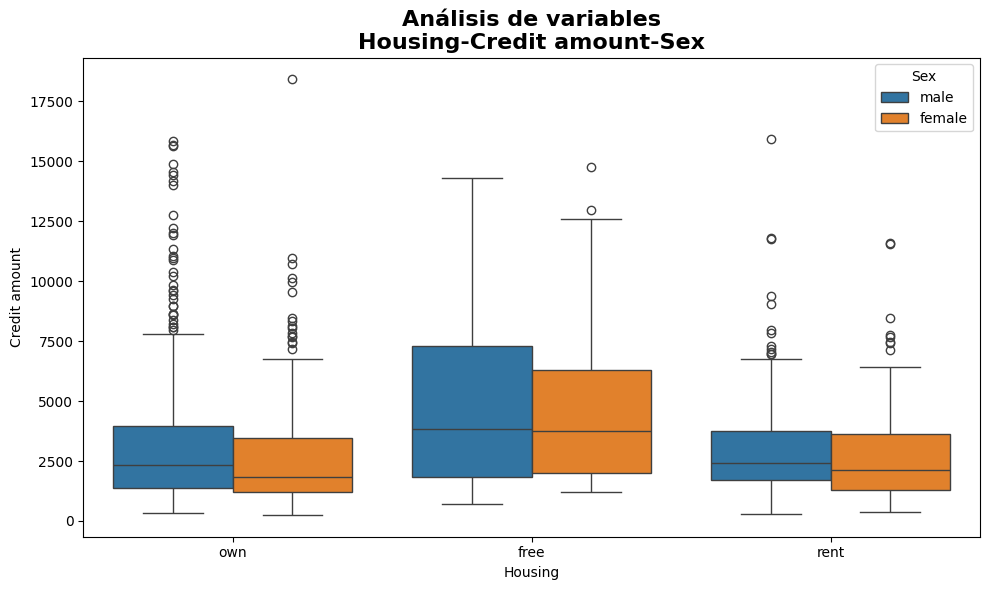

In [26]:
boxes("Housing","Credit amount","Sex",r=0)

En t√©rminos de categor√≠a de vivienda, no hay gran diferencia a pesar de que las personas que tienen una vivienda ‚Äúgratuita‚Äù tienden a solicitar montos de cr√©dito ligeramente mayores.

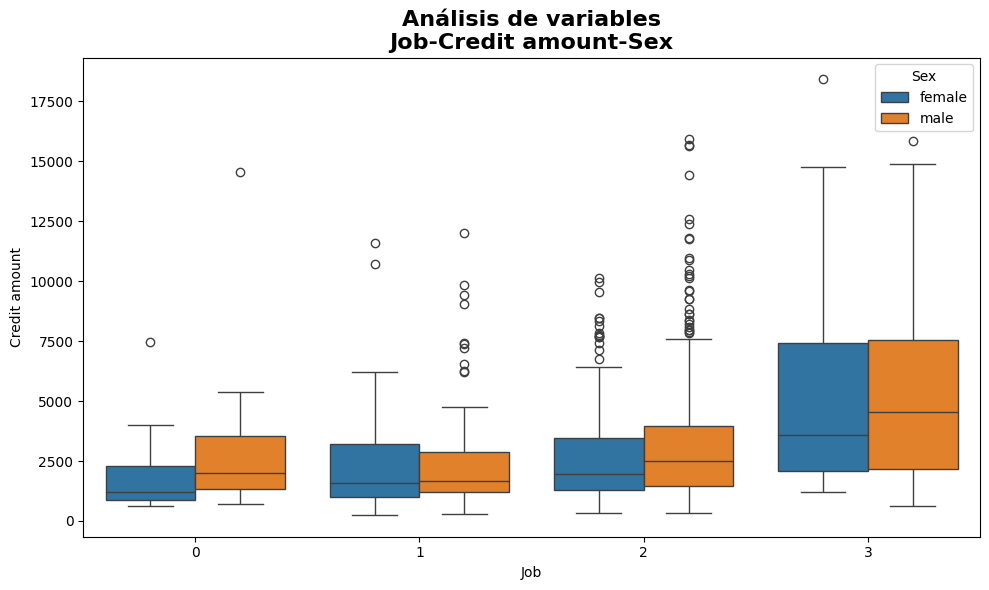

In [27]:
boxes("Job","Credit amount","Sex",r=0)

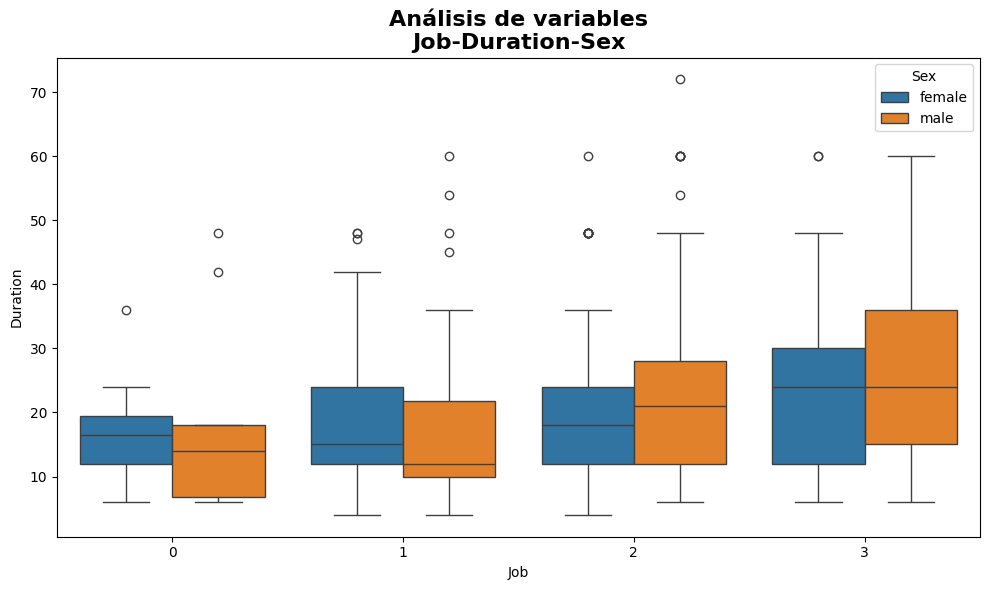

In [28]:
boxes("Job","Duration","Sex",r=0)

En t√©rminos de categor√≠a laboral, una vez m√°s no hay diferencia entre hombres y mujeres; sin embargo, es posible ver que la categor√≠a laboral 3 tiende a aceptar montos de cr√©dito mayores por mayor duraci√≥n.



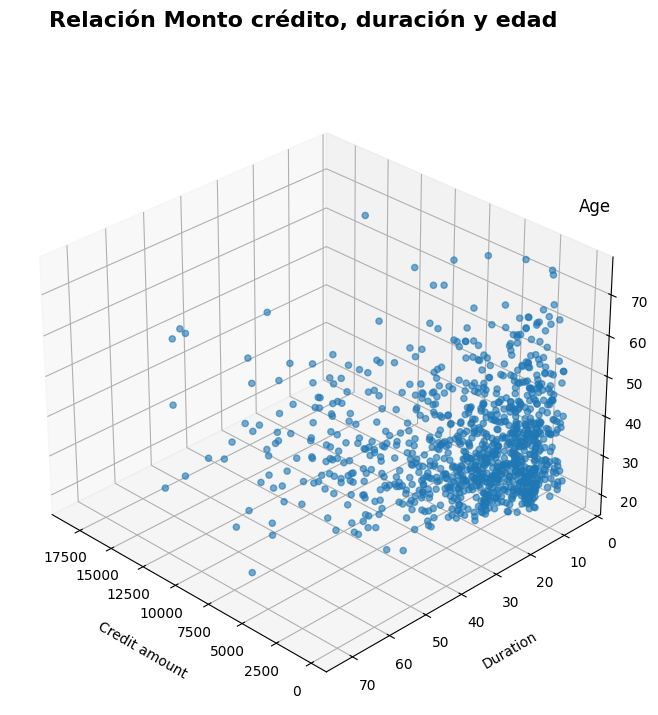

In [56]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Dispersi√≥n
ax.scatter(data["Credit amount"], data["Duration"], data["Age"], alpha=0.6)

# Etiquetas X e Y normales
ax.set_xlabel("Credit amount", labelpad=12)
ax.set_ylabel("Duration", labelpad=12)

# Insertar texto en 3D como etiqueta del eje Z
x_pos = data["Credit amount"].min()
y_pos = data["Duration"].min()
z_pos = data["Age"].max() + 15

ax.text(x_pos, y_pos, z_pos, "Age", fontsize=12, color="black", rotation=90)

# Ajuste visual
ax.view_init(elev=30, azim=135)
plt.subplots_adjust(top=0.88)
plt.suptitle("Relaci√≥n Monto cr√©dito, duraci√≥n y edad", fontsize=16, fontweight="bold")

plt.show()


#Agrupaci√≥n con KMeans

Para la agrupaci√≥n, se crear√° un subconjunto que contenga s√≥lo variables num√©ricas (edad, monto del cr√©dito, duraci√≥n).

In [47]:
# Selecci√≥n de columnas para realizar la segmentaci√≥n
selected_cols = ["Age","Credit amount", "Duration"]
cluster_data = data.loc[:,selected_cols]

Se crear√° una funci√≥n que traza tres histogramas, uno para cada variable.

In [48]:
def distributions(df : pd.DataFrame):
  fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,8))
  fig.suptitle("Distribuciones", fontsize=16, fontweight="bold")
  sns.distplot(df["Age"], ax=ax1)
  sns.distplot(df["Credit amount"], ax=ax2)
  sns.distplot(df["Duration"], ax=ax3)
  plt.tight_layout()
  plt.subplots_adjust(top=0.85)



---


**Visualizaci√≥n de los histogramas**



---



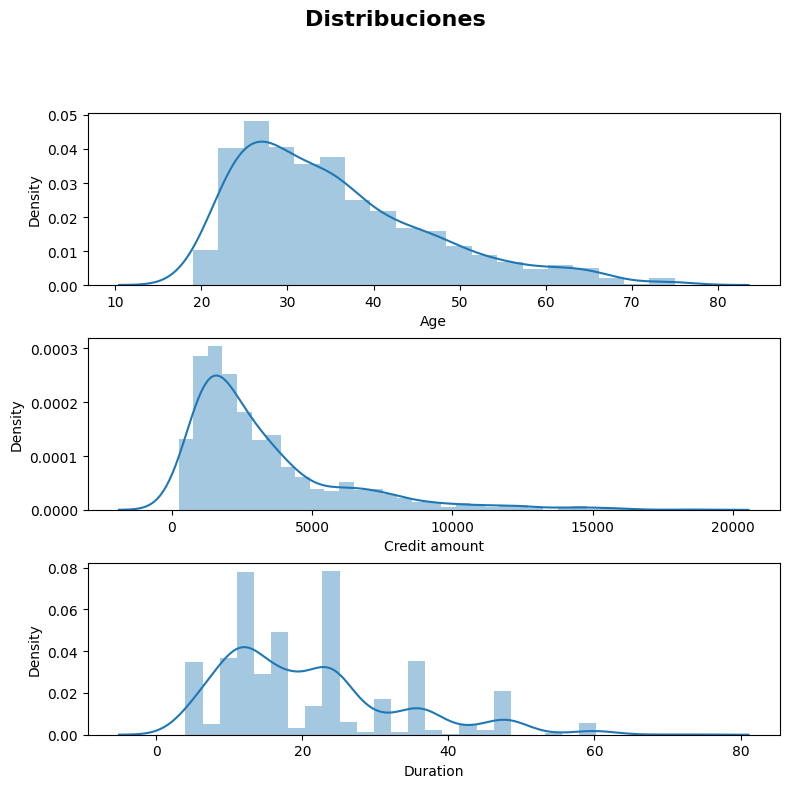

In [49]:
distributions(cluster_data)



---

**Eliminaci√≥n de la asimetr√≠a**

---

Es posible ver que las distribuciones est√°n sesgadas hacia la derecha. Para obtener mejores resultados se debe eliminar la asimetr√≠a mediante transformaci√≥n logar√≠tmica. Despu√©s de eso se analiza c√≥mo quedan.

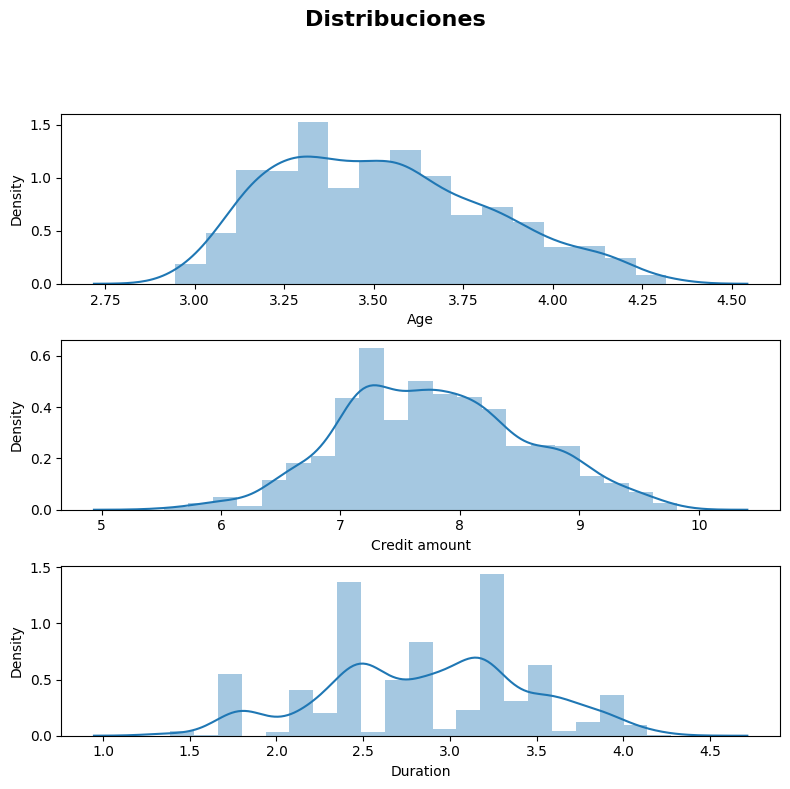

In [50]:
cluster_log = np.log(cluster_data)
distributions(cluster_log)

De hecho, se ha eliminado la asimetr√≠a.

El siguiente paso ser√° centrar y escalar las variables; esto lo requiere el algoritmo KMeans. Se usar√° para eso **StandardScaler** de la biblioteca **sklearn**.

In [51]:
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster_log)

Se revisa c√≥mo cambia la inercia para varios grupos.

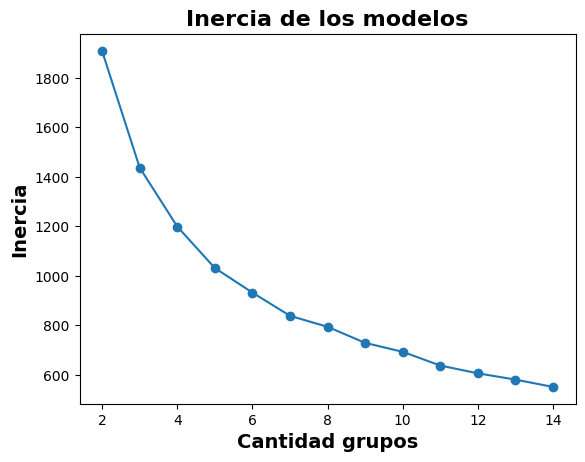

In [52]:
clusters_range = range(2,15)
inertias =[]

for c in clusters_range:
  kmeans = KMeans(n_clusters=c, random_state=0).fit(cluster_scaled)
  inertias.append(kmeans.inertia_)

plt.figure()
plt.plot(clusters_range,inertias, marker='o')
plt.title("Inercia de los modelos", fontsize=16, fontweight="bold")
plt.xlabel("Cantidad grupos", fontsize=14, fontweight="bold")
plt.ylabel("Inercia", fontsize=14, fontweight="bold")
plt.show()

El gr√°fico anterior muestra que la inercia disminuye a medida que aumenta el n√∫mero de grupos.

Este m√©todo permite evaluar las separaciones de los conglomerados y ajustar cada observaci√≥n en su propio conglomerado. Cuanto m√°s alto sea el puntaje, mejor. Tambi√©n se va a realizar este an√°lisis para varias semillas.

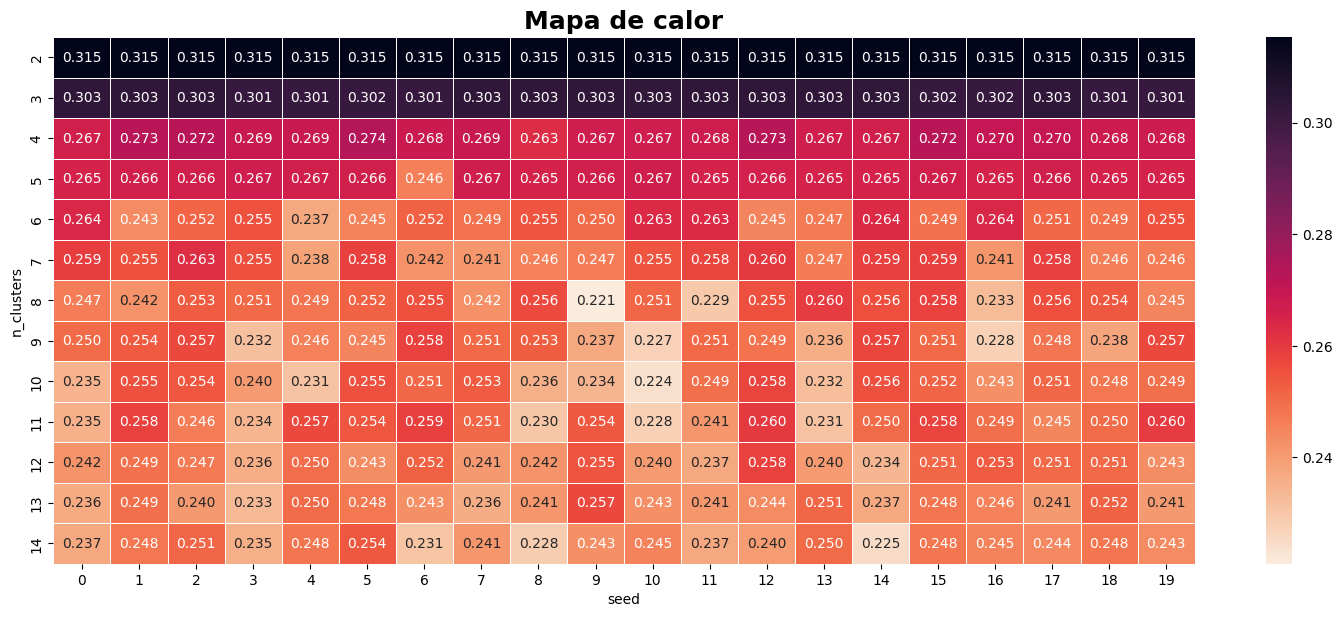

In [53]:
clusters_range = range(2,15)
random_range = range(0,20)
results =[]
for c in clusters_range:
    for r in random_range:
        clusterer = KMeans(n_clusters=c, random_state=r)
        cluster_labels = clusterer.fit_predict(cluster_scaled)
        silhouette_avg = silhouette_score(cluster_scaled, cluster_labels)
        #print("For n_clusters =", c," and seed =", r,  "\nThe average silhouette_score is :", silhouette_avg)
        results.append([c,r,silhouette_avg])

result = pd.DataFrame(results, columns=["n_clusters","seed","silhouette_score"])
pivot_km = pd.pivot_table(result, index="n_clusters", columns="seed",values="silhouette_score")

plt.figure(figsize=(15,6))
sns.heatmap(pivot_km, annot=True, linewidths=.5, fmt='.3f', cmap=sns.cm.rocket_r)
plt.tight_layout()
plt.title("Mapa de calor", fontsize=18, fontweight="bold");

El mapa de calor anterior muestra puntuaciones de Silhouette para varias combinaciones de estado aleatorio y n√∫mero de grupos.

Los puntajes m√°s altos son para racimos 2 y 3 y son relativamente insensibles a la semilla.

Se elegir√°n 3 grupos para obtener m√°s informaci√≥n sobre los datos.

In [57]:
kmeans_sel = KMeans(n_clusters=3, random_state=29).fit(cluster_scaled)
labels = pd.DataFrame(kmeans_sel.labels_)
clustered_data = cluster_data.assign(Cluster=labels)

A continuaci√≥n, se crea un gr√°fico de Silhouette para 3 grupos para representar visualmente el ajuste de cada punto dentro de su propio grupo (c√≥digo modificado del documento scikit-learn).

Para n_clusters = 3  y seed = 19 
El promedio silhouette_score es : 0.301686616517302


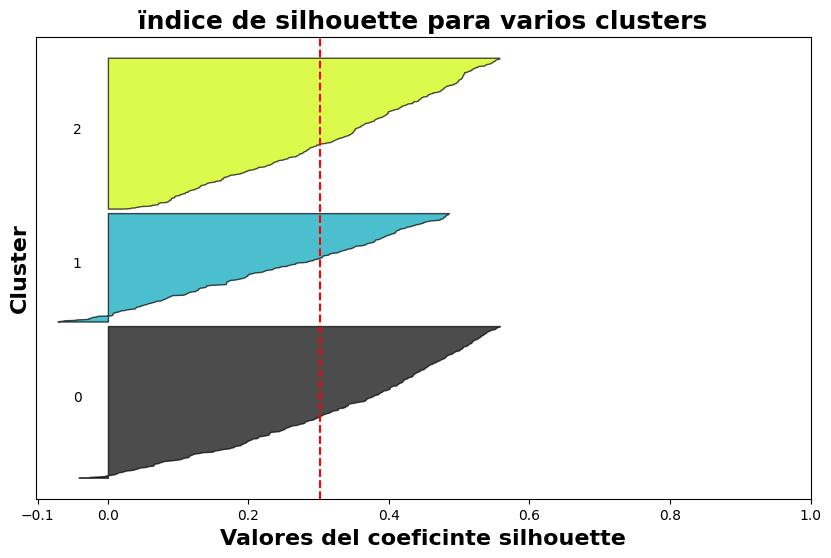

In [63]:
clusterer = KMeans(n_clusters=3, random_state=29)
cluster_labels = clusterer.fit_predict(cluster_scaled)
silhouette_avg = silhouette_score(cluster_scaled, cluster_labels)
print("Para n_clusters =", 3," y seed =", r,  "\nEl promedio silhouette_score es :", silhouette_avg)

# Calcula el √≠ndice de silohoutte para cada ejemplo
sample_silhouette_values = silhouette_samples(cluster_scaled, cluster_labels)

fig, ax1 = plt.subplots(figsize=(10,6))

y_lower = 10
for i in range(3):
  # Agrega el √≠ndice calculado para el i.√©simo cluster y ordena
  ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
  ith_cluster_silhouette_values.sort()

  size_cluster_i = ith_cluster_silhouette_values.shape[0]
  y_upper = y_lower + size_cluster_i

  color = cm.nipy_spectral(float(i) / 3)
  ax1.fill_betweenx(np.arange(y_lower, y_upper),0, ith_cluster_silhouette_values, facecolor=color, edgecolor="black", alpha=0.7)

  # Label the silhouette plots with their cluster numbers at the middle
  ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

  # Compute the new y_lower for next plot
  y_lower = y_upper + 10  # 10 for the 0 samples

ax1.get_yaxis().set_ticks([])
ax1.set_title("√Øndice de silhouette para varios clusters", fontsize=18, fontweight="bold")
ax1.set_xlabel("Valores del coeficinte silhouette", fontsize=16, fontweight="bold")
ax1.set_ylabel("Cluster", fontsize=16, fontweight="bold")
# L√≠nea verticar para el √≠ndice promedio
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1]);

üß† **Interpretaciones**

1. Promedio general aceptable

La l√≠nea roja est√° entre 0.2 y 0.3, lo cual sugiere que hay estructura moderada en los datos, pero los clusters no est√°n muy bien definidos.

2. Cluster 0 (negro)

Es el m√°s numeroso.

Tiene una distribuci√≥n mayoritariamente positiva, pero varios puntos con silueta baja (~0.1).

Posible mezcla con otros clusters.

3. Cluster 1 (celeste)

Es peque√±o.

Siluetas relativamente estables, pero algunos puntos cercanos a 0, lo cual indica poca separaci√≥n respecto a otros grupos.

4. Cluster 2 (amarillo)

Bastante cohesivo.

La mayor√≠a de sus puntos tienen coeficientes de silueta altos (> 0.3), lo que sugiere que es un grupo bien separado.



‚úÖ **Conclusiones**

El n√∫mero de clusters podr√≠a ser adecuado. Sin embargo, hay se√±ales de:

+ Algunos puntos mal asignados o ambig√ºedad en la separaci√≥n (coeficientes bajos o cercanos a 0).

+ Un cluster dominante (cluster 0) que puede estar capturando demasiada variabilidad

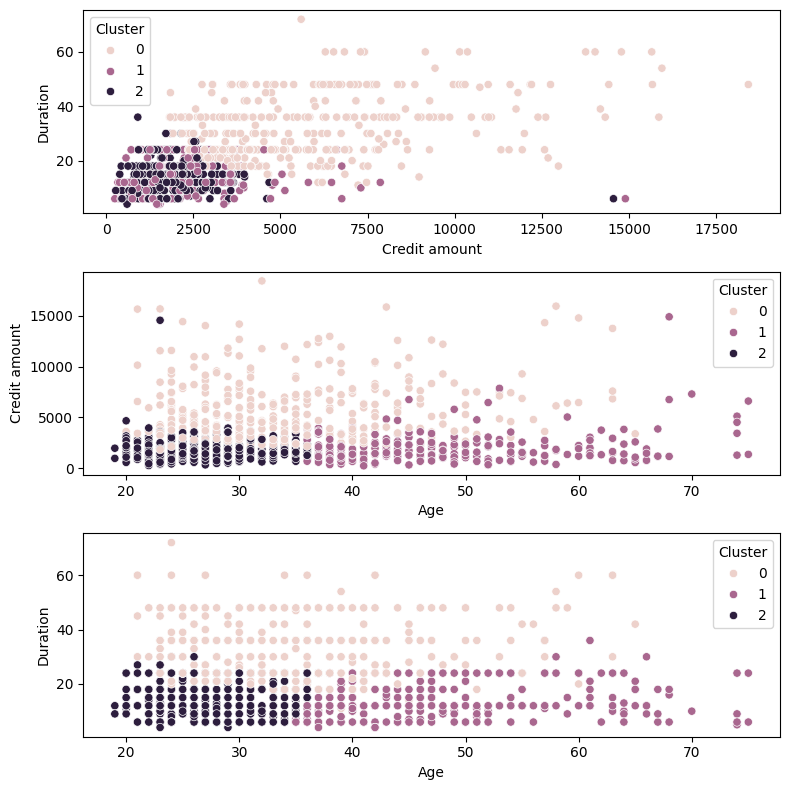

In [59]:
scatters(clustered_data, 'Cluster')

Los gr√°ficos de arriba muestran tres grupos creados. En los gr√°ficoss inferiores muestran una separaci√≥n de grupos relativamente clara, pero no es tan evidente en el superior.

Ahora se genera un gr√°fico de mapa de calor para facilitar la interpretaci√≥n empresarial de la segmentaci√≥n de clientes.

In [60]:
clustered_data

Age  Credit amount  Duration  Cluster
0     67           1169         6        1
1     22           5951        48        0
2     49           2096        12        1
3     45           7882        42        0
4     53           4870        24        0
..   ...            ...       ...      ...
995   31           1736        12        2
996   40           3857        30        0
997   38            804        12        1
998   23           1845        45        0
999   27           4576        45        0

[1000 rows x 4 columns]

In [61]:
grouped_km = clustered_data.groupby(['Cluster']).mean().round(1)
grouped_km

Age  Credit amount  Duration
Cluster                               
0        34.3         5724.1      32.3
1        48.3         1947.5      13.6
2        27.6         1757.3      14.6

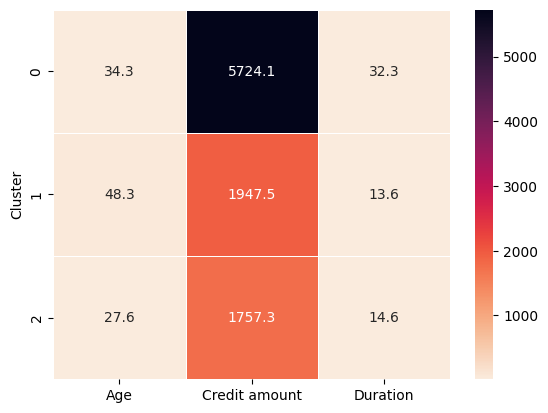

In [62]:
sns.heatmap(grouped_km, annot=True, linewidths=.5, fmt='.1f', cmap=sns.cm.rocket_r);